In [1]:
import os, collections

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.collections as mc

MAIN = __name__ == "__main__"

# Parse Timetable

In [2]:
def load_original_timetable(filepath):
    # wrt v5, rename original_day_ix and original_hour_ix
    df = pd.read_csv(filepath, dtype={'subject': str})
    
    df["day_ix"] = df["original_day_ix"]
    df["hour_ix"] = df["original_hour_ix"]
    
    assert "subject" in df.columns
    assert "class_num" in df.columns
    assert "proc_time" in df.columns
    assert "venue" in df.columns    
    return df

def make_records(df, idx_col):
    idxs = df[idx_col]
    record_list = df.to_dict('records')
    return {k:v for k,v in zip(idxs, record_list)}

In [3]:
df_ref_job = load_original_timetable("./reference/TT Data.csv")
ref_job = make_records(df_ref_job, "job_ix")
# ref_instructor = make_records(pd.read_csv("./reference/reference - instructor.csv").fillna(0), "subject_ix")
ref_subject = make_records(pd.read_csv("./reference/reference - subject.csv").fillna(0), "subject_ix")
ref_venue = make_records(pd.read_csv("./reference/reference - venue.csv"), "venue_ix")
ref_time = make_records(pd.read_csv("./reference/reference - time.csv"), "time_ix")
df_ref_job

,job_ix,subject,class_num,proc_time,instructor,venue,term,term_half,precedence,original_day,...,release_date,deadline,track_avi,track_ba,track_fin,track_scl,track_uis,track_core,day_ix,hour_ix
0,1,40.004,CS01,4,BD,2.404,ESD T5,1,1,TUE,...,0,999,0,0,0,0,0,1,2,10.0
1,2,40.004,CS01,4,BD,2.404,ESD T5,1,2,THU,...,0,999,0,0,0,0,0,1,4,10.0
2,3,40.004,CS02,4,BD,2.404,ESD T5,1,1,TUE,...,0,999,0,0,0,0,0,1,2,13.0
3,4,40.004,CS02,4,BD,2.404,ESD T5,1,2,THU,...,0,999,0,0,0,0,0,1,4,13.0
4,5,40.012,CS01,4,SS,2.404,ESD T5,1,1,MON,...,0,999,0,0,0,0,0,1,1,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,65,1.106,LP01,6,(TAE) TTHD,1.509,TAE,2,1,TUE,...,28,33,0,0,0,0,0,0,2,10.0
65,66,1.107,CS01,4,(TAE) LC,2.31,TAE,2,1,TUE,...,28,31,1,0,0,0,1,0,2,10.0
66,67,1.107,CS01,4,(TAE) LC,2.31,TAE,2,2,THU,...,60,63,1,0,0,0,1,0,4,9.0
67,68,1.111,CP01,6,(TAE) JH,2.405,TAE,2,1,TUE,...,28,33,0,0,0,0,0,0,2,10.0


In [4]:
# extrack track subjects
track_subjects = collections.defaultdict(set)

for subject_info in ref_subject.values():
    subject, subject_ix, *tracks = subject_info
    for track in tracks:
        if subject_info[track]:
            track_subjects[track].add(subject_info[subject])

track_subjects

defaultdict(set,
            {'track_core': {'40.004', '40.012', '40.014'},
             'track_fin': {'40.242', '40.323'},
             'track_ba': {'01.104', '40.302', '40.305', '40.319'},
             'track_scl': {'40.302', '40.305'},
             'track_avi': {'01.107', '40.321'},
             'track_uis': {'01.107'}})

# Extract subset
We will only plot a subset of the timetable

In [5]:
df_sample = df_ref_job[(df_ref_job["term"] == "ESD T5")&(df_ref_job["term_half"] == 1)]
df_sample = df_sample[["subject", "class_num", "venue", "day_ix", "hour_ix", "proc_time", "instructor"]]
df_sample

,subject,class_num,venue,day_ix,hour_ix,proc_time,instructor
0,40.004,CS01,2.404,2,10.0,4,BD
1,40.004,CS01,2.404,4,10.0,4,BD
2,40.004,CS02,2.404,2,13.0,4,BD
3,40.004,CS02,2.404,4,13.0,4,BD
4,40.012,CS01,2.404,1,8.5,4,SS
5,40.012,CS01,2.404,3,8.5,4,SS
6,40.012,CS02,2.505,1,13.0,4,SS
7,40.012,CS02,2.505,3,11.5,4,SS
8,40.012,LS01,2.505,5,10.5,2,SS
9,40.014,CS01,2.503/2.504,2,13.0,4,PLJ


# Plot timetable

In [6]:
def organize_timetable(df, post_process_times=True):
    # organise the classes on each days to separate rows if overlapping, for visualisation
    # "subject", "class_code", "venue", "day_ix", "hour_ix", "proc_time"
    df = df.copy()
    
    if post_process_times:
        df["day_index"] = df["day_ix"]-1
        df["hour_index"] = df["hour_ix"]
        df["proc_time"] = df["proc_time"]/2
    
    records = df.to_dict('records')
    records = sorted(records, key=lambda x:(x["day_index"],x["hour_index"],x["proc_time"]))

    timetable = [[[]] for _ in range(5)]

    for record in records:
        pidx = 0  # parallel index
        while True:
            if timetable[record["day_index"]][pidx] == []:
                timetable[record["day_index"]][pidx].append(record)
                timetable[record["day_index"]].append([])
                break
            if timetable[record["day_index"]][pidx][-1]["hour_index"] \
             + timetable[record["day_index"]][pidx][-1]["proc_time"] <= record["hour_index"]:
                timetable[record["day_index"]][pidx].append(record)
                break
            pidx += 1
    
    timetable = [parallels[:-1] for parallels in timetable]
    return timetable

if MAIN:
    organized_timetable = organize_timetable(df_sample)
    # organized_timetable[0]

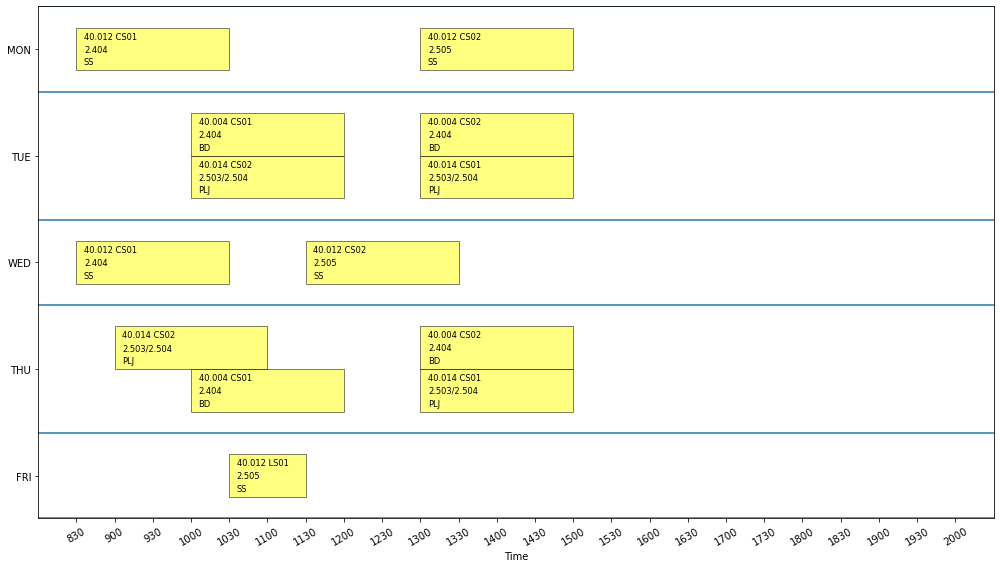

In [7]:
def plot_organised_timetable(organized_timetable, save_path="", show_fig=False, title="", highlighted_track=""):

    fig = plt.figure(figsize=(14,8), facecolor=(1, 1, 1))
    ax = plt.gca()

    def add_rectangle(ax, locx, locy, height, width, color="white"):
        ax.add_patch(patches.Rectangle((locx, locy), height, width, edgecolor="black",
                                       facecolor=color, alpha=0.5))

    def add_text(ax, locx, locy, text, offset=0.1):
        locx += offset
        locy += offset
        ax.text(locx, locy, text, verticalalignment='top', size='smaller')

    def add_horizontal_line(ax, y_intercept):
        ax.axhline(y_intercept)

    yptr = 1
    days_label_yptr = []
    add_horizontal_line(ax, 0.5)
    for day_schedule in organized_timetable:
        day_start_yptr = yptr
        for parallel_day_schedule in day_schedule:
            for record in parallel_day_schedule:
                xptr = record["hour_index"]
                width = record["proc_time"]
                color = "white"
                if record["subject"] in track_subjects[highlighted_track]:
                    color = "yellow"
                add_rectangle(ax, xptr, yptr, width, 1, color=color)
                add_text(ax, xptr, yptr, record["subject"] + " " + record["class_num"])
                add_text(ax, xptr, yptr+0.3, record["venue"])
                add_text(ax, xptr, yptr+0.6, record["instructor"])
            yptr += 1
        day_end_yptr = yptr
        days_label_yptr.append((day_end_yptr + day_start_yptr)/2)
        add_horizontal_line(ax, yptr+0.5)
        yptr += 1

    day_code_to_day_index = {time["day"]:time["day_ix"]-1 for time in ref_time.values()}
    time_hour_to_hour_index = {time["hour_ix"]:time["hour"] for time in ref_time.values()}
    days_label = sorted(day_code_to_day_index, key=lambda x: day_code_to_day_index[x])
    
    plt.xlabel("Time")
    plt.xticks(*list(zip(*time_hour_to_hour_index.items())), rotation=30)
    plt.yticks(days_label_yptr, days_label)
    plt.xlim(16/2,41/2)
    plt.ylim(0.5,yptr-0.5)
    plt.title(title)
    ax.invert_yaxis()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    if show_fig:
        plt.show()
    plt.close()

if MAIN:
    plot_organised_timetable(organized_timetable, show_fig=True, highlighted_track="track_core")

# Term 7 timetable

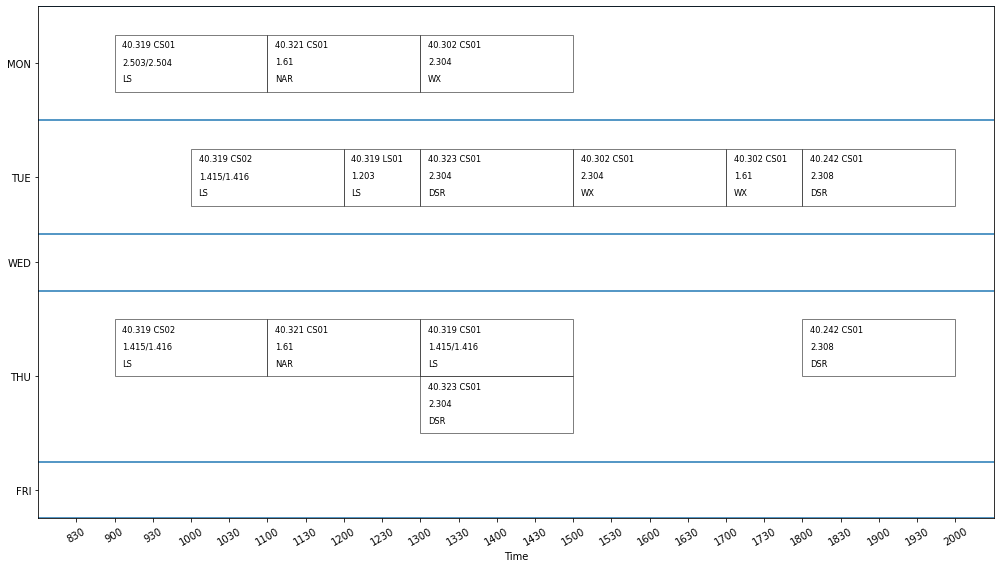

In [8]:
if MAIN:
    df_sample = df_ref_job[(df_ref_job["term"] == "ESD T7")&(df_ref_job["term_half"] == 1)]
    organized_timetable = organize_timetable(df_sample)
    plot_organised_timetable(organized_timetable, show_fig=True)

# Plot all relevant timetables

In [9]:
def analyse_related_features(df_output, folder_output="./", hardcode=False):
    if not os.path.exists(folder_output):  # create folder if does not exist
        os.makedirs(folder_output)

    organized_timetable = organize_timetable(df_output)
    plot_organised_timetable(organized_timetable,
                             title="Complete Timetable",
                             save_path="{}/all.png".format(folder_output))

    # term 5 timetable
    df_subset = df_output[df_output["term"] == "ESD T5"]
    organized_timetable = organize_timetable(df_subset)
    plot_organised_timetable(organized_timetable, 
                             title="Term 5 ESD modules",
                             save_path="{}/comb-ESD-T5.png".format(folder_output))

    # term 5 cohort 1 timetable
    df_cohort = df_subset[(df_subset["class_num"] == "CS01") | (df_subset["class_num"] == "LS01")]
    if hardcode:
        pass
    organized_timetable = organize_timetable(df_cohort)
    plot_organised_timetable(organized_timetable, 
                             title="Term 5 ESD modules - cohort 1",
                             save_path="{}/comb-ESD-T5-cohort-1.png".format(folder_output))

    # term 5 cohort 2 timetable
    df_cohort = df_subset[(df_subset["class_num"] == "CS02") | (df_subset["class_num"] == "LS01")]
    if hardcode:
        pass
    organized_timetable = organize_timetable(df_cohort)
    plot_organised_timetable(organized_timetable, 
                             title="Term 5 ESD modules - cohort 2",
                             save_path="{}/comb-ESD-T5-cohort-2.png".format(folder_output))

    # term 7 timetable
    df_subset = df_output[df_output["term"] != "ESD T5"]
    organized_timetable = organize_timetable(df_subset)
    plot_organised_timetable(organized_timetable, 
                             title="Term 7 ESD modules",
                             save_path="{}/comb-ESD-T7.png".format(folder_output))
    
    # plotting for each track
    for track in track_subjects:
        if track == "" or track == "track_core":
            continue
        plot_organised_timetable(organized_timetable, highlighted_track=track,
                                 title="Term 7 ESD modules - Track: {}".format(track), 
                                 save_path="{}/comb-ESD-T7-track-{}.png".format(folder_output, track))
    
    # plotting for each instructor, venue, subject concerned
    for instructor in set(df_output["instructor"]):
        df_subset = df_output[df_output["instructor"] == instructor]  
        organized_timetable = organize_timetable(df_subset)
        plot_organised_timetable(organized_timetable, 
                                 title="For instructor {}".format(instructor),
                                 save_path="{}/instructor-{}.png".format(folder_output, instructor))
    
    for venue in set(df_output["venue"]):
        for sub_venue in venue.split("/"):
            df_subset = df_output[df_output["venue"].str.contains(sub_venue)]
            organized_timetable = organize_timetable(df_subset)
            plot_organised_timetable(organized_timetable, 
                                     title="For venue {}".format(venue),
                                     save_path="{}/venue-{}.png".format(folder_output, sub_venue))
    
    for subject in set(df_output["subject"]):
        df_subset = df_output[df_output["subject"] == subject]
        organized_timetable = organize_timetable(df_subset)
        plot_organised_timetable(organized_timetable, 
                                 title="For subject {}".format(subject),
                                 save_path="{}/subject-{}.png".format(folder_output, subject))

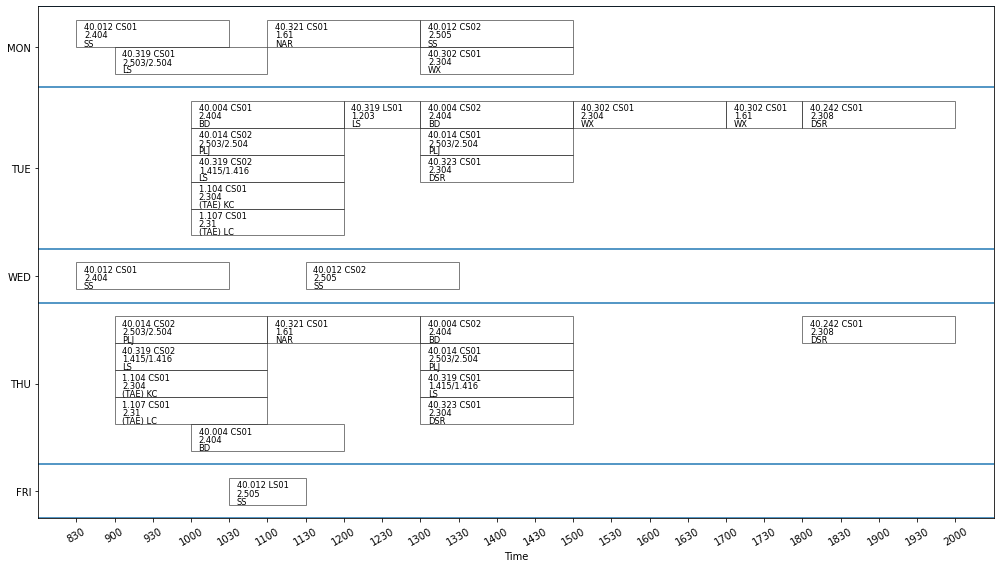

In [10]:
if MAIN:
    df_output = df_ref_job[df_ref_job["term_half"] == 1]
    organized_timetable = organize_timetable(df_output)
    plot_organised_timetable(organized_timetable, show_fig=True)  # show master
    analyse_related_features(df_output, folder_output="given-timetable")

# Parsing a sample result

In [11]:
results = '''
X[1,26,17] 1
X[2,26,29] 1
X[3,26,1] 1
X[4,26,47] 1
X[5,26,10] 1
X[6,26,52] 1
X[7,33,5] 1
X[8,33,26] 1
X[9,33,60] 1
X[10,32,6] 1
X[11,32,25] 1
X[12,32,19] 1
X[13,32,32] 1
X[27,20,12] 1
X[28,20,28] 1
X[29,17,21] 1
X[30,17,29] 1
X[31,12,57] 1
X[32,32,1] 1
X[33,6,49] 1
X[34,6,14] 1
X[35,6,75] 1
X[36,1,34] 1
X[37,12,5] 1
X[38,12,29] 1
X[39,17,1] 1
X[40,17,33] 1
X[54,17,11] 1
X[55,17,25] 1
X[56,8,88] 1
X[57,8,1] 1
X[58,21,1] 1
X[59,21,25] 1
X[60,27,1] 1
X[61,27,88] 1
'''.strip()
results = [list(map(int,result.split("]")[0].split("[")[1].split(','))) for result in results.split('\n')]
results # job_ix, venue_ix, time_ix

[[1, 26, 17],
 [2, 26, 29],
 [3, 26, 1],
 [4, 26, 47],
 [5, 26, 10],
 [6, 26, 52],
 [7, 33, 5],
 [8, 33, 26],
 [9, 33, 60],
 [10, 32, 6],
 [11, 32, 25],
 [12, 32, 19],
 [13, 32, 32],
 [27, 20, 12],
 [28, 20, 28],
 [29, 17, 21],
 [30, 17, 29],
 [31, 12, 57],
 [32, 32, 1],
 [33, 6, 49],
 [34, 6, 14],
 [35, 6, 75],
 [36, 1, 34],
 [37, 12, 5],
 [38, 12, 29],
 [39, 17, 1],
 [40, 17, 33],
 [54, 17, 11],
 [55, 17, 25],
 [56, 8, 88],
 [57, 8, 1],
 [58, 21, 1],
 [59, 21, 25],
 [60, 27, 1],
 [61, 27, 88]]

In [12]:
def parse_results(results):
    records = []
    for job_ix, venue_ix, time_ix in results:
        venue = ref_venue[venue_ix]
        time = ref_time[time_ix]
        job = ref_job[job_ix]
        record = {
            "day_ix": time["day_ix"],
            "hour_ix": time["hour_ix"],
            "proc_time": job["proc_time"],
            "venue": venue["venue"],
            "class_num": job["class_num"],
            "subject": job["subject"],
            "instructor": job["instructor"],
            "term": job["term"]
        }
        records.append(record)
    return pd.DataFrame.from_records(records)

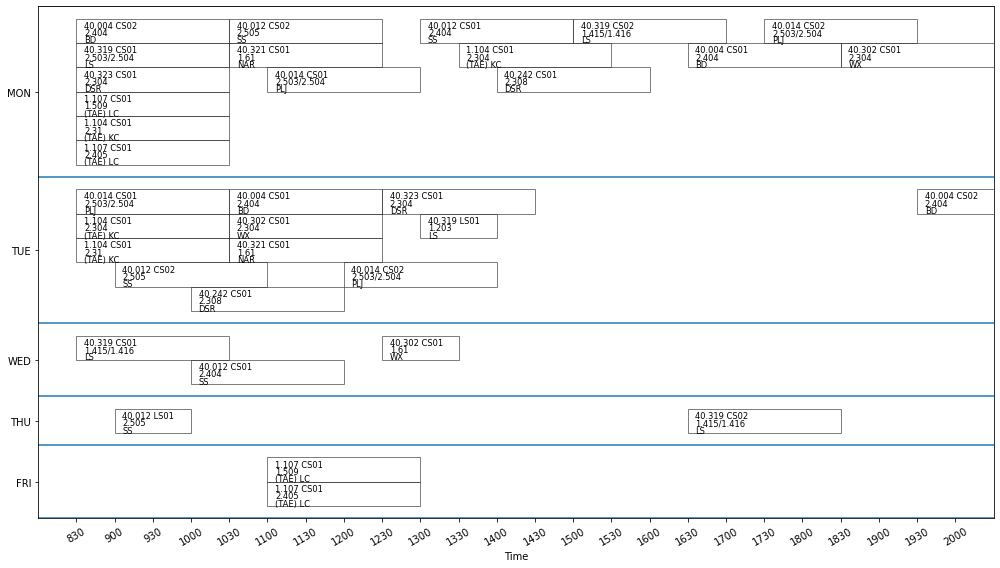

In [13]:
if MAIN:
    df_output = parse_results(results)
    organized_timetable = organize_timetable(df_output)
    plot_organised_timetable(organized_timetable, show_fig=True)  # show master
    analyse_related_features(df_output, folder_output="sample-parsed-timetable")

(for versioning purposes)

In [14]:
if MAIN:
    get_ipython().system('jupyter nbconvert --to script viz.ipynb')

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook viz.ipynb to script
[NbConvertApp] Writing 11638 bytes to viz.py
